# Ignition Example

The following is a streamlined approach using YAML input to specify simulated conditions.

In [1]:
import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings(action='error')
warnings.filterwarnings("ignore", ".*Using or importing the ABCs from *")

In [2]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


## 1. Function/Class Definitions

In [3]:
import cantera as ct
import ctwrap as cw
cw.__version__

/home/ischoegl/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


'0.1.0'

## 2. Simulations

### 2.1 Create Simulation object

Uses a module in the `modules` folder. Modules do not have to depend on `ctwrap`.

In [4]:
sim = cw.Simulation.from_module(cw.modules.ignition)
sim

In [5]:
%%time
sim.run()

CPU times: user 622 ms, sys: 9.8 ms, total: 632 ms
Wall time: 656 ms


### 2.2 Create Simulation Handler

Parameters are specified via YAML file

In [6]:
# create variation object
fname = 'ignition.yaml'
sh = cw.SimulationHandler.from_yaml(fname, verbosity=1)
sh

Simulation tasks for `initial.phi`: [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]


In [7]:
sh.configuration(1.0)

{'initial': {'T': [1000.0, 'kelvin', 'initial temperature'],
  'P': [1.0, 'atmosphere', 'pressure'],
  'phi': [1.0, 'dimensionless', 'equivalence ratio'],
  'fuel': 'H2',
  'oxidizer': 'O2:1,AR:3.76'},
 'chemistry': {'mechanism': 'h2o2.xml', 'path': ''},
 'simulation': {'delta_t': 1e-05,
  'n_points': 500,
  'atol': 1e-15,
  'rtol': 1e-09,
  'max_time_step': 1e-06}}

### 2.3 Run serial simulation

In [8]:
%%time
sh.run_serial(sim, verbosity=1)

 * processing `initial.phi`: 0.4
 * processing `initial.phi`: 0.6
 * processing `initial.phi`: 0.8
 * processing `initial.phi`: 1.0
 * processing `initial.phi`: 1.2
 * processing `initial.phi`: 1.4
 * processing `initial.phi`: 1.6
 * processing `initial.phi`: 1.8
CPU times: user 4.66 s, sys: 33.8 ms, total: 4.69 s
Wall time: 4.68 s


True

### 2.4 Run parallel simulation

In [9]:
%%time
sh.run_parallel(sim)

 * running simulation using 8 cores
 * processing `initial.phi`: 0.4 (Process-1)
 * processing `initial.phi`: 0.6 (Process-2)
 * processing `initial.phi`: 0.8 (Process-3)
 * processing `initial.phi`: 1.0 (Process-4)
 * processing `initial.phi`: 1.2 (Process-5)
 * processing `initial.phi`: 1.4 (Process-6)
 * processing `initial.phi`: 1.6 (Process-7)
 * processing `initial.phi`: 1.8 (Process-8)
CPU times: user 17.5 ms, sys: 45.3 ms, total: 62.9 ms
Wall time: 904 ms


True

## 3. Create graphical output

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

col = mpl.rcParams['axes.prop_cycle'].by_key()['color']

### 3.1 Load data from file

In [11]:
# load data from output file
data = cw.fileio.from_hdf(sh.oname)
data.keys()

dict_keys(['configuration', 'phi=0.4', 'phi=0.6', 'phi=0.8', 'phi=1.0', 'phi=1.2', 'phi=1.4', 'phi=1.6', 'phi=1.8', 'variation'])

In [12]:
# eliminate entries containing documentation
config = data.pop('configuration')
variation = data.pop('variation')
variation

{'configuration_entry': ['initial', 'phi'],
 'tasks': [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]}

### 3.2 Plot

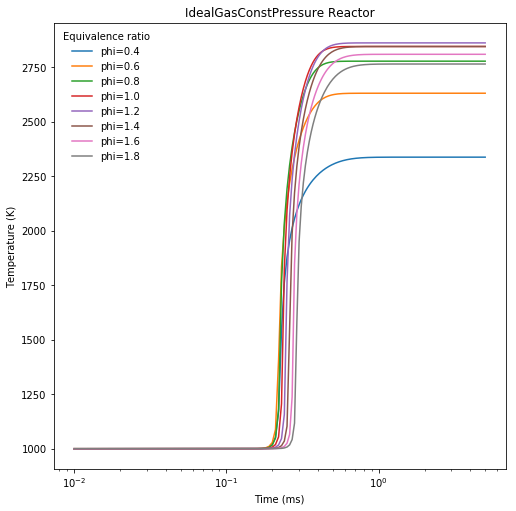

In [13]:
# create figure and adjust size/spacing
fig, ax = plt.subplots(1) #
fig.set_size_inches(8.,8.,forward=True)
fig.subplots_adjust(hspace=0,bottom=.125,top=.9,left=.17,right=.955)

# plot results
for f, key in enumerate(data):
    df = data[key]
    ax.semilogx(1000*df['t (s)'],df['T (K)'],color=col[f],label=key) 

# add title/axis labels
ax.set_title(r'IdealGasConstPressure Reactor')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Temperature (K)')

# add legend
leg = ax.legend(loc='upper left',#prop={'size':11},
                title='Equivalence ratio') # % mech)
leg.draw_frame(False) 

# show and save
plt.show()